# Notes

sampling methods
- simple random sampling
- stratified random sampling
- cluster sampling
- systematic sampling
- convenience sampling
- judgement sampling

Hypothesis testing
- null and alternative
- reject null -> type I error (alpha)
- accept null -> type II error (beta)
- random sample / matched sample
- test of independence

ANOVA
- comparing means
- bonferroni correction and other techniques for correcting error rates
- randomized block design
- 2-factor design

Linear regression
- 5 assumptions of linear regression
- significance: t test and F test
    - caution: no casual relationship / extrapolation
- residuals plots
- check for outlier and influential observation
    - remove to see impact
    - leverage and cook's distance
- check for multicollinearity

In [130]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry
import seaborn as sns
import plotly.express as px
import re
from matplotlib.colors import TwoSlopeNorm
import missingno as msno
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import math
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import itertools
from linear_reg_diagnostics import Linear_Reg_Diagnostics # custom module

In [2]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
pd.set_option('display.max_columns', None)

In [3]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [4]:
# Projected Coordinate System: how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System: how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

In [5]:
neighbourhoods = gpd.read_file('./clean_data/neighbourhoods.geojson', driver='GeoJSON')
neighbourhood_years = sorted(list(set([re.search('\d+', x).group(0) for x in neighbourhoods.columns if re.search('\d+', x) is not None])))
neighbourhoods_select = neighbourhoods[['Hood_ID'] + 
                                       ['Population_' + x for x in neighbourhood_years]]
neighbourhoods_select = neighbourhoods_select.copy()
# extrapolate population in 2021 based on population growth rate from 2019 to 2020
neighbourhoods_select['Population_2021'] = (neighbourhoods_select['Population_2020'] * neighbourhoods_select['Population_2020'] / neighbourhoods_select['Population_2019']).values
neighbourhoods_population = pd.wide_to_long(neighbourhoods_select, stubnames='Population', i='Hood_ID', j='Year', sep='_').reset_index()
neighbourhoods_population

Hood_ID  Year    Population
0         97  2014  12597.000000
1         27  2014  28719.000000
2         38  2014  16086.000000
3         31  2014  15196.000000
4         16  2014  25636.000000
...      ...   ...           ...
1115      46  2021  16985.994859
1116      94  2021  16351.031153
1117      56  2021  18969.209689
1118     108  2021  15620.936759
1119      17  2021  39658.358942

[1120 rows x 3 columns]

In [6]:
distance_df = neighbourhoods[['Hood_ID', 'distance_km']]
distance_df

Hood_ID  distance_km
0        97     2.791462
1        27    13.676191
2        38    10.427749
3        31     7.592207
4        16     9.017845
..      ...          ...
135      46    14.643244
136      94     2.864021
137      56     5.149543
138     108     6.111904
139      17     9.894878

[140 rows x 2 columns]

In [7]:
mci_df = pd.read_csv('./clean_data/mci_select.csv')[['occurrencedate', 'MCI', 'Hood_ID', 'Neighbourhood']]
mci_df = mci_df.copy()
mci_df['occurrencedate'] = pd.to_datetime(mci_df['occurrencedate']).dt.tz_localize(None)
mci_df.set_index('occurrencedate', inplace=True)
mci_df['Hood_ID'] = mci_df['Hood_ID'].astype(str)
mci_df = mci_df.loc[(mci_df['Hood_ID'] != 'NSA') & (mci_df['MCI'] != 'Shootings') & (mci_df['MCI'] != 'Homicide')]
mci_df = mci_df.groupby('Hood_ID').resample('Q').size().T.reset_index().melt(id_vars='occurrencedate', var_name='Hood_ID', value_name='MCI_Count')
mci_df['Year'] = mci_df['occurrencedate'].dt.year
mci_df = mci_df.merge(neighbourhoods_population, on=['Hood_ID', 'Year'])
mci_df['MCI_Rate'] = mci_df['MCI_Count'].div(mci_df['Population']).mul(10**5)
mci_df

C:\Users\willi\AppData\Local\Temp\ipykernel_26872\1039957768.py:1: DtypeWarning:

Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.



occurrencedate Hood_ID  MCI_Count  Year    Population    MCI_Rate
0        2014-03-31       1        191  2014  34745.000000  549.719384
1        2014-06-30       1        262  2014  34745.000000  754.065333
2        2014-09-30       1        206  2014  34745.000000  592.891063
3        2014-12-31       1        228  2014  34745.000000  656.209527
4        2015-03-31       1        159  2015  34557.000000  460.109384
...             ...     ...        ...   ...           ...         ...
4475     2020-12-31      99         24  2020  17972.000000  133.541064
4476     2021-03-31      99         22  2021  18133.437233  121.322834
4477     2021-06-30      99         40  2021  18133.437233  220.586971
4478     2021-09-30      99         31  2021  18133.437233  170.954903
4479     2021-12-31      99         34  2021  18133.437233  187.498926

[4480 rows x 6 columns]

In [8]:
collision_df = pd.read_csv('./clean_data/collision_point.csv')[['occurrencedate', 'Hood_ID', 'Neighbourhood']]
collision_df = collision_df.copy()
collision_df['occurrencedate'] = pd.to_datetime(collision_df['occurrencedate']).dt.tz_localize(None)
collision_df.set_index('occurrencedate', inplace=True)
collision_df['Hood_ID'] = collision_df['Hood_ID'].astype(str)
collision_df = collision_df.loc[(collision_df['Hood_ID'] != 'NSA')]
collision_df = collision_df.groupby('Hood_ID').resample('Q').size().T.reset_index().melt(id_vars='occurrencedate', var_name='Hood_ID', value_name='Collision_Count')
collision_df['Year'] = collision_df['occurrencedate'].dt.year
collision_df = collision_df.merge(neighbourhoods_population, on=['Hood_ID', 'Year'])
collision_df['Collision_Rate'] = collision_df['Collision_Count'].div(collision_df['Population']).mul(10**5)
collision_df

occurrencedate Hood_ID  Collision_Count  Year    Population  \
0        2014-03-31       1              352  2014  34745.000000   
1        2014-06-30       1              300  2014  34745.000000   
2        2014-09-30       1              317  2014  34745.000000   
3        2014-12-31       1              312  2014  34745.000000   
4        2015-03-31       1              334  2015  34557.000000   
...             ...     ...              ...   ...           ...   
4195     2020-06-30      99               37  2020  17972.000000   
4196     2020-09-30      99               80  2020  17972.000000   
4197     2020-12-31      99               74  2020  17972.000000   
4198     2021-03-31      99               54  2021  18133.437233   
4199     2021-06-30      99               45  2021  18133.437233   

      Collision_Rate  
0        1013.095409  
1         863.433588  
2         912.361491  
3         897.970931  
4         966.519084  
...              ...  
4195      205.875807  
4196      445.136880  
4197      411.751614  
4198      297.792411  
4199      248.160343  

[4200 rows x 6 columns]

In [9]:
neighborhoods_rental = gpd.read_file('./clean_data/neighbourhoods_rental.geojson')
neighborhoods_rental = neighborhoods_rental[neighborhoods_rental['Year'] >= 2014]
neighborhoods_rental = neighborhoods_rental[['Hood_ID', 'Year', 'Quarter', 'All_Apartments_Leased_vs_Listed', 'All_Apartments_Avg_Lease_Rate_Per_Room']]
neighborhoods_rental['occurrencedate'] = pd.date_range(start = str(neighborhoods_rental.Year.min()) + '-01-01', 
                                                       end = str(neighborhoods_rental.Year.max()) + '-12-31', 
                                                       freq = 'Q').tolist() * len(neighborhoods_rental.Hood_ID.unique())
neighborhoods_rental

Hood_ID  Year  Quarter  All_Apartments_Leased_vs_Listed  \
8         97  2014        1                         0.414530   
9         97  2014        2                         0.437768   
10        97  2014        3                         0.474708   
11        97  2014        4                         0.338028   
12        97  2015        1                         0.320210   
...      ...   ...      ...                              ...   
5595     104  2020        4                         0.389210   
5596     104  2021        1                         0.428866   
5597     104  2021        2                         0.571429   
5598     104  2021        3                         0.743938   
5599     104  2021        4                         0.647555   

      All_Apartments_Avg_Lease_Rate_Per_Room occurrencedate  
8                                2023.736111     2014-03-31  
9                                2112.973510     2014-06-30  
10                               2299.291667     2014-09-30  
11                               2292.481481     2014-12-31  
12                               2298.331461     2015-03-31  
...                                      ...            ...  
5595                             1589.607422     2020-12-31  
5596                             1544.625239     2021-03-31  
5597                             1547.933680     2021-06-30  
5598                             1628.854754     2021-09-30  
5599                             1685.476768     2021-12-31  

[4480 rows x 6 columns]

In [10]:
neighborhoods_rental = neighborhoods_rental[['Hood_ID', 'All_Apartments_Leased_vs_Listed', 'All_Apartments_Avg_Lease_Rate_Per_Room', 'occurrencedate']]
mci_df = mci_df[['Hood_ID', 'occurrencedate', 'MCI_Rate']]
collision_df = collision_df[['Hood_ID', 'occurrencedate', 'Collision_Rate']]
regression_table = neighborhoods_rental.merge(mci_df, on=['Hood_ID', 'occurrencedate'], how='outer').merge(collision_df, on=['Hood_ID', 'occurrencedate'], how='outer').merge(distance_df, on=['Hood_ID'], how='outer')
regression_table.ffill(inplace=True)

In [11]:
Y = 'All_Apartments_Avg_Lease_Rate_Per_Room'
Xs = ['All_Apartments_Leased_vs_Listed', 'MCI_Rate', 'Collision_Rate', 'distance_km']
regression_table[['Hood_ID', 'occurrencedate'] + [Y] + Xs]

Hood_ID occurrencedate  All_Apartments_Avg_Lease_Rate_Per_Room  \
0         97     2014-03-31                             2023.736111   
1         97     2014-06-30                             2112.973510   
2         97     2014-09-30                             2299.291667   
3         97     2014-12-31                             2292.481481   
4         97     2015-03-31                             2298.331461   
...      ...            ...                                     ...   
4475     104     2020-12-31                             1589.607422   
4476     104     2021-03-31                             1544.625239   
4477     104     2021-06-30                             1547.933680   
4478     104     2021-09-30                             1628.854754   
4479     104     2021-12-31                             1685.476768   

      All_Apartments_Leased_vs_Listed    MCI_Rate  Collision_Rate  distance_km  
0                            0.414530   79.383980      539.811066     2.791462  
1                            0.437768  174.644757      468.365484     2.791462  
2                            0.474708  150.829563      404.858300     2.791462  
3                            0.338028   95.260776      476.303882     2.791462  
4                            0.320210   94.147183      478.581516     2.791462  
...                               ...         ...             ...          ...  
4475                         0.389210  253.220302      104.590994     4.632290  
4476                         0.428866  245.989395      134.897410     4.632290  
4477                         0.571429  235.409206      126.962268     4.632290  
4478                         0.743938  193.088450      126.962268     4.632290  
4479                         0.647555  251.279489      126.962268     4.632290  

[4480 rows x 7 columns]

In [12]:
regression_df = regression_table[[Y] + Xs].copy()
regression_df.rename(columns={'All_Apartments_Avg_Lease_Rate_Per_Room': 'Rent',
                              'All_Apartments_Leased_vs_Listed': 'Lease_Demand',
                              'MCI_Rate': 'Crime',
                              'Collision_Rate': 'Traffic_Collisions',
                              'distance_km': 'Distance'}, inplace=True)
Y = 'Rent'
Xs = ['Lease_Demand', 'Crime', 'Traffic_Collisions', 'Distance']

# Correlation plot
- The first row of correlation matrix shows the correlation between our dependent variable (Rent) and other independent variables. 
- It makes sense that distance from the University of Toronto has a negative correlation with rent since you need to spend more time on commute if you live further away from the city centre.
- given the strong correlation between crime and traffic collision, we might need to check if there is  multicollinearity
- The first row of pairplot shows the linear regression results between Y and Xs

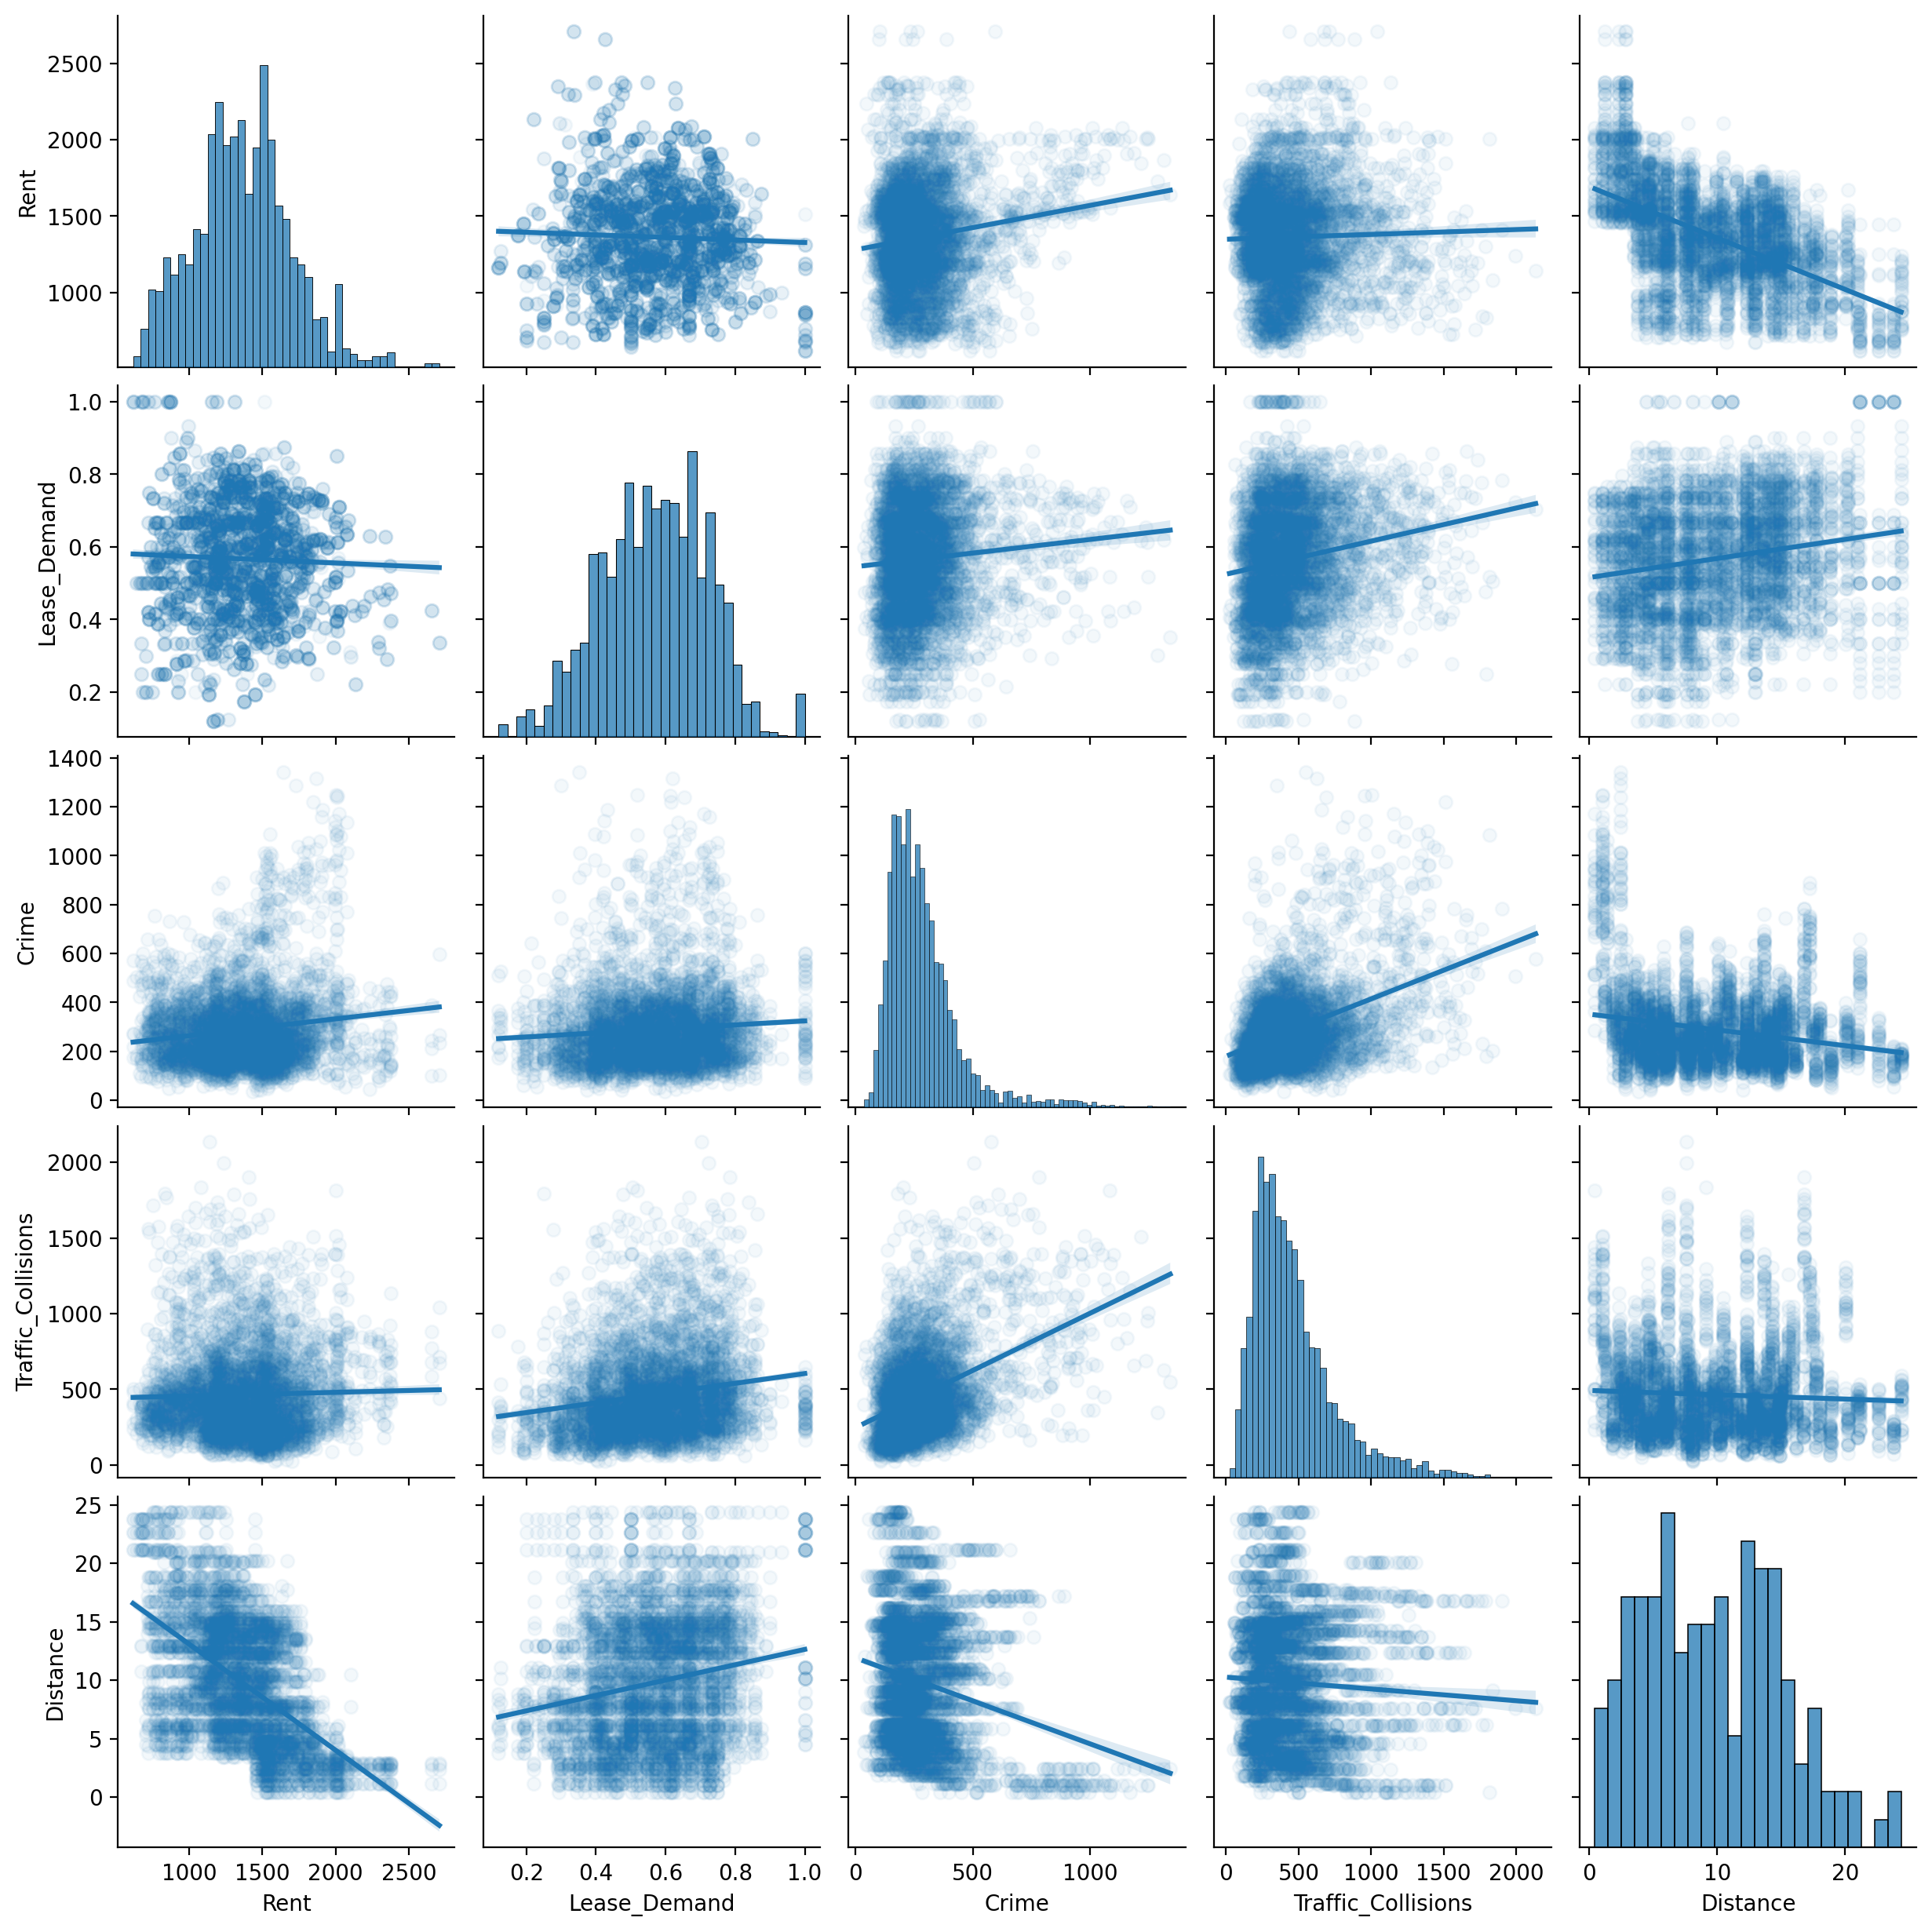

In [13]:
sns.pairplot(regression_df, 
             kind = 'reg', 
             diag_kind='hist', 
             plot_kws={'scatter_kws': {'alpha':0.05}})

# Regression result

In [160]:
# Run regression on all available variables as a start
results = smf.ols(formula = 'Rent ~ Lease_Demand + Crime + Traffic_Collisions + Distance',
                  data = regression_df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rent   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     502.9
Date:                Sun, 08 May 2022   Prob (F-statistic):               0.00
Time:                        09:56:55   Log-Likelihood:                -31533.
No. Observations:                4480   AIC:                         6.308e+04
Df Residuals:                    4475   BIC:                         6.311e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1613.5947     18.107     89.115      0.000    1578.096    1649.093
Lease_Demand         145.9589     27.737      5.262      0.000      91.581     200.337
Crime                  0.0491      0.029      1.700      0.089      -0.008       0.106
Traffic_Collisions    -0.0275      0.016     -1.731      0.084      -0.059       0.004
Distance             -34.1712      0.792    -43.140      0.000     -35.724     -32.618
==============================================================================
Omnibus:                       28.073   Durbin-Watson:                   0.229
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.203
Skew:                          -0.057   Prob(JB):                     3.07e-09
Kurtosis:                       3.444   Cond. No.                     4.67e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## First take
> While Crime and Traffic Collisions look like insignificant based on the t tests, we need to first rule out the impact from
> - outliers, 
> - influential observations and 
> - multicollinearity

In [163]:
cls = Linear_Reg_Diagnostics(results)

### No outliers and influential observations
- Outliers may represent erroneous data which should be corrected
- Influential observations are observations far from its mean (i.e. observations with high leverage)
  - They can have a strong impact on the value of parameters estimated, rendering any t test or F test useless in measuing model's performance
- Cook's distance measures both leverage and residual of each observation
  -  Cook's distance > 1 indicates an influential observation that can severly impact the regression results

<AxesSubplot:title={'center':'Studentized Residuals vs Leverage'}, xlabel='Leverage', ylabel='Studentized Residuals'>

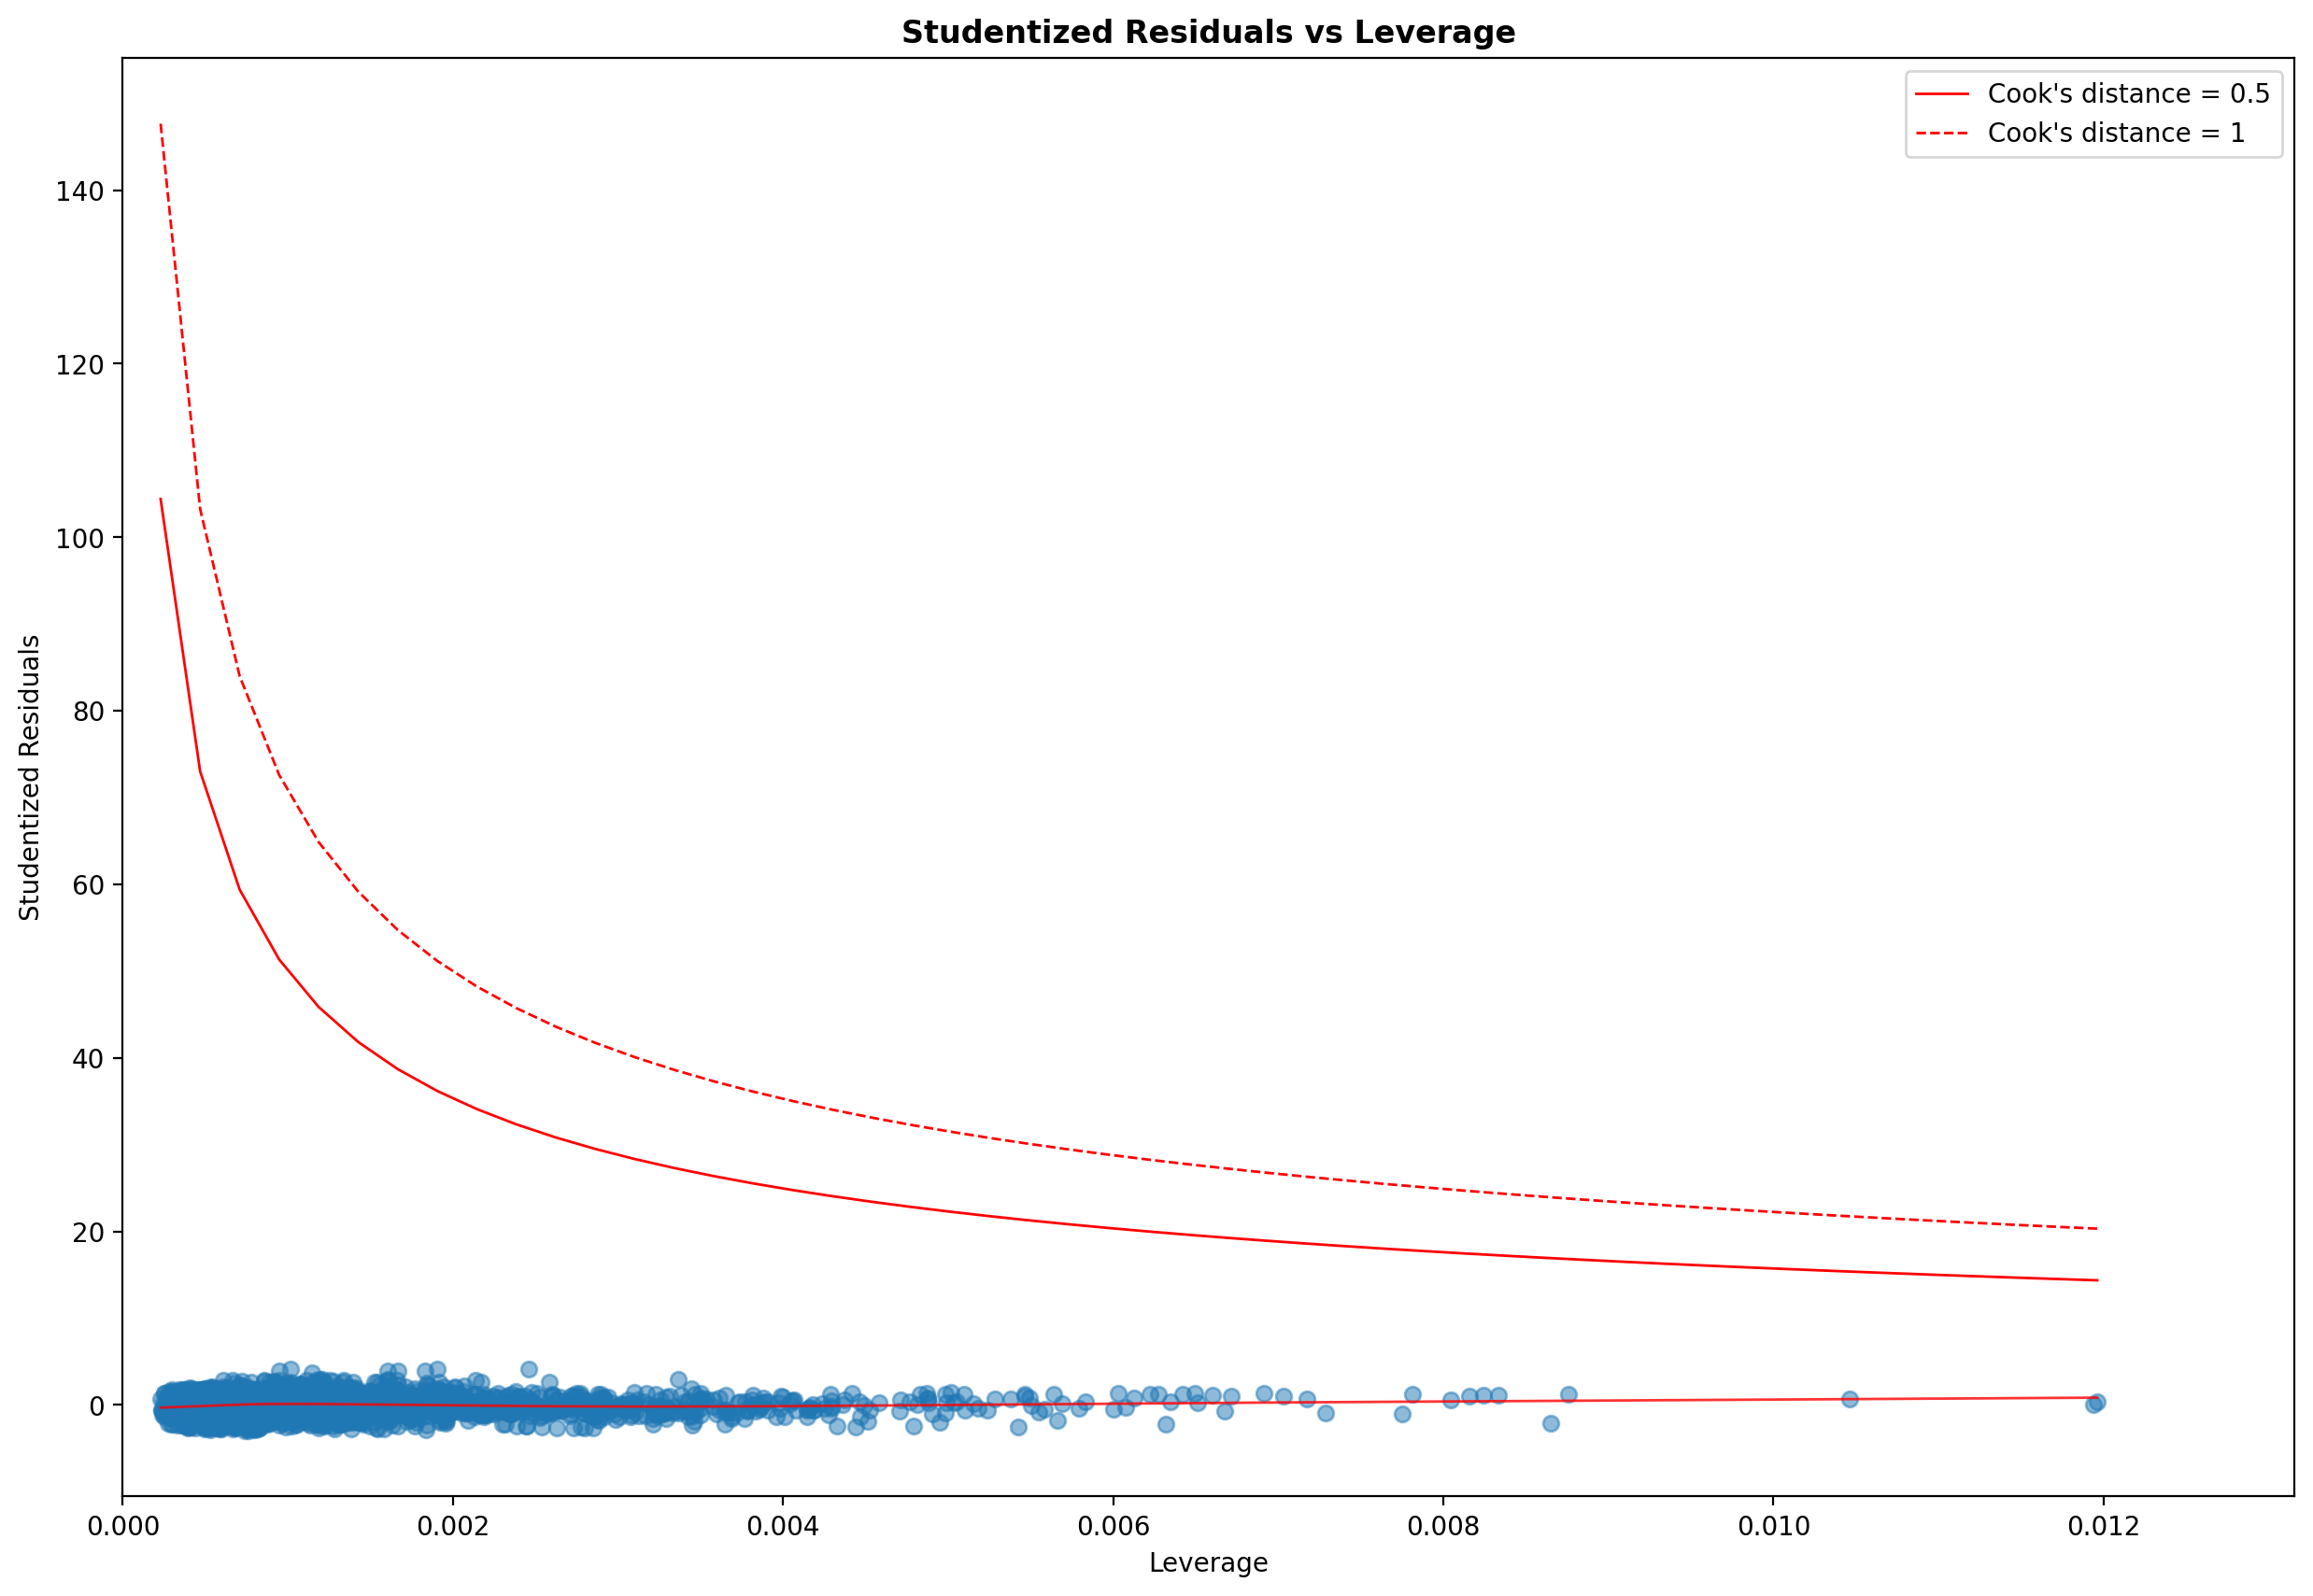

In [164]:
# All residuals have Cook's distance < 1 (or 0.5) -> no outlier
cls.leverage_plot()

### No significant multicollinearity between independent variables

Nonsignificant t-tests for crime (p-value = 0.089) and traffic_collisions (p-value = 0.084) when the F-test for overall model adequacy is significant might suggest multicollinearity

Why is it a problem?
1) Hard to interpret the parameters as the sign can become opposite
2) Hard to make inferences about the parameters as standard errors can be wrong

Check for below signs:
1) Significant correlations between independent variables
2) Variance inflation factor (VIF) > 10

<AxesSubplot:>

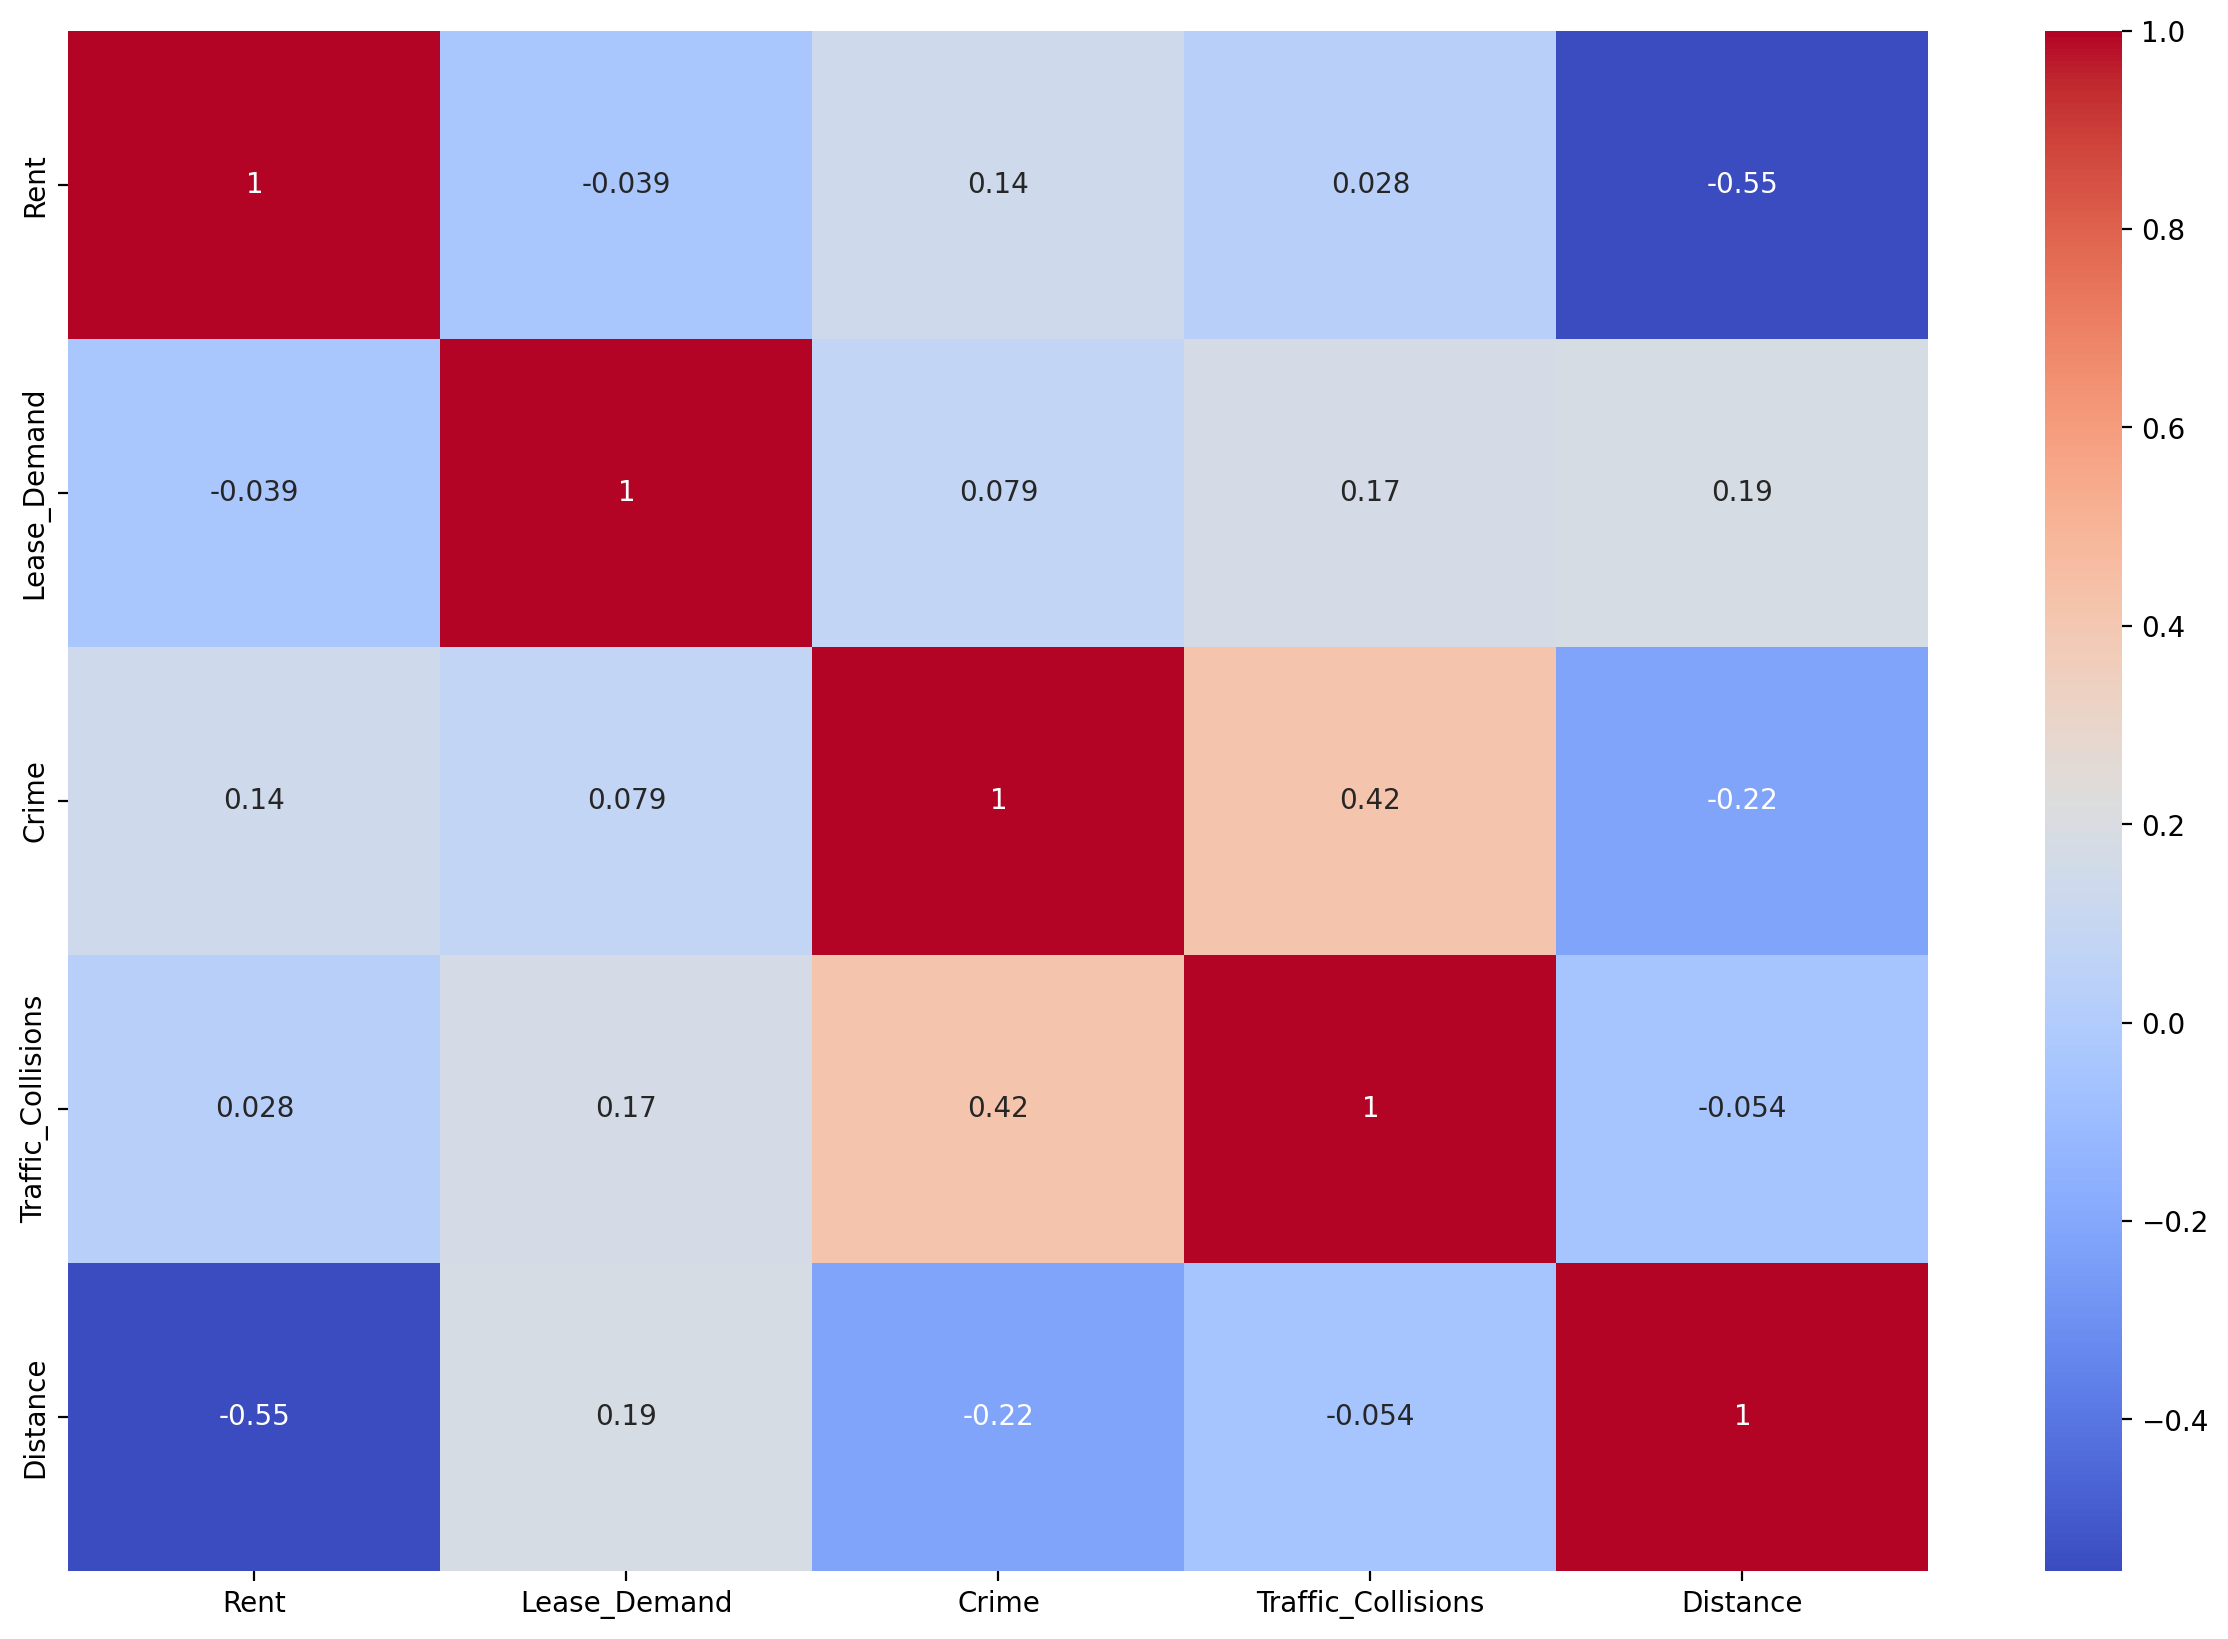

In [17]:
# Noticeable correlation between crime and traffic collisions (42%)
sns.heatmap(regression_df.corr(), annot=True, cmap='coolwarm')

In [18]:
# Variance inflation factor is too small to suggest substantial multicollinearity
for i, x in enumerate(Xs):
    rsq = smf.ols(formula = x + ' ~ ' + ' + '.join(np.delete(Xs, i)), data = regression_df).fit().rsquared
    print(f"VIF for {x} is {1/(1-rsq):0.2f}")

VIF for Lease_Demand is 1.08
VIF for Crime is 1.28
VIF for Traffic_Collisions is 1.24
VIF for Distance is 1.10


## Best-subsets regression
- Variable selection procedure for a specified number of independent variables based on adjusted R square
- Given there is no significant benefit from including variables other than distance, let's use that as our model

In [19]:
for i in range(len(Xs)):
    n = i + 1
    best_rsq = 0
    best_combo = []
    for combo in itertools.combinations(Xs, n):
        rsq_adj = smf.ols(formula = 'Rent ~ ' + ' + '.join(combo), data = regression_df).fit().rsquared_adj
        if rsq_adj > best_rsq:
            best_combo = combo
            best_rsq = rsq_adj
    print(f"Best adjusted R squared = {best_rsq:0.3f} (Rent ~ {' + '.join(best_combo)})")

Best adjusted R squared = 0.305 (Rent ~ Distance)
Best adjusted R squared = 0.309 (Rent ~ Lease_Demand + Distance)
Best adjusted R squared = 0.309 (Rent ~ Lease_Demand + Traffic_Collisions + Distance)
Best adjusted R squared = 0.310 (Rent ~ Lease_Demand + Crime + Traffic_Collisions + Distance)


In [20]:
# Run regression on distance only
best_subset = smf.ols(formula = 'Rent ~ Lease_Demand + Distance',
                  data = regression_df).fit()
best_subset.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rent   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     1003.
Date:                Sat, 07 May 2022   Prob (F-statistic):               0.00
Time:                        18:16:34   Log-Likelihood:                -31535.
No. Observations:                4480   AIC:                         6.308e+04
Df Residuals:                    4477   BIC:                         6.310e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1619.0488     16.401     98.714      0.000    1586.894    1651.204
Lease_Demand   142.5907     27.229      5.237      0.000      89.209     195.972
Distance       -34.3916      0.770    -44.686      0.000     -35.900     -32.883
==============================================================================
Omnibus:                       26.840   Durbin-Watson:                   0.230
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.930
Skew:                          -0.074   Prob(JB):                     1.58e-08
Kurtosis:                       3.413   Cond. No.                         84.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Residual diagnostics

To conduct hypothesis testing of regression coefficients and form prediction intervals of future values of y, we must satisfy the following assumptions:
- (1) ε is normally distributed,
- (2) with a mean of 0, 
- (3) the variance σ^2 is constant, and 
- (4) all pairs of error terms are uncorrelated

<img src="./source/img/2022-05-08-00-44-27.png">
<img src="./source/img/2022-05-08-00-45-04.png">

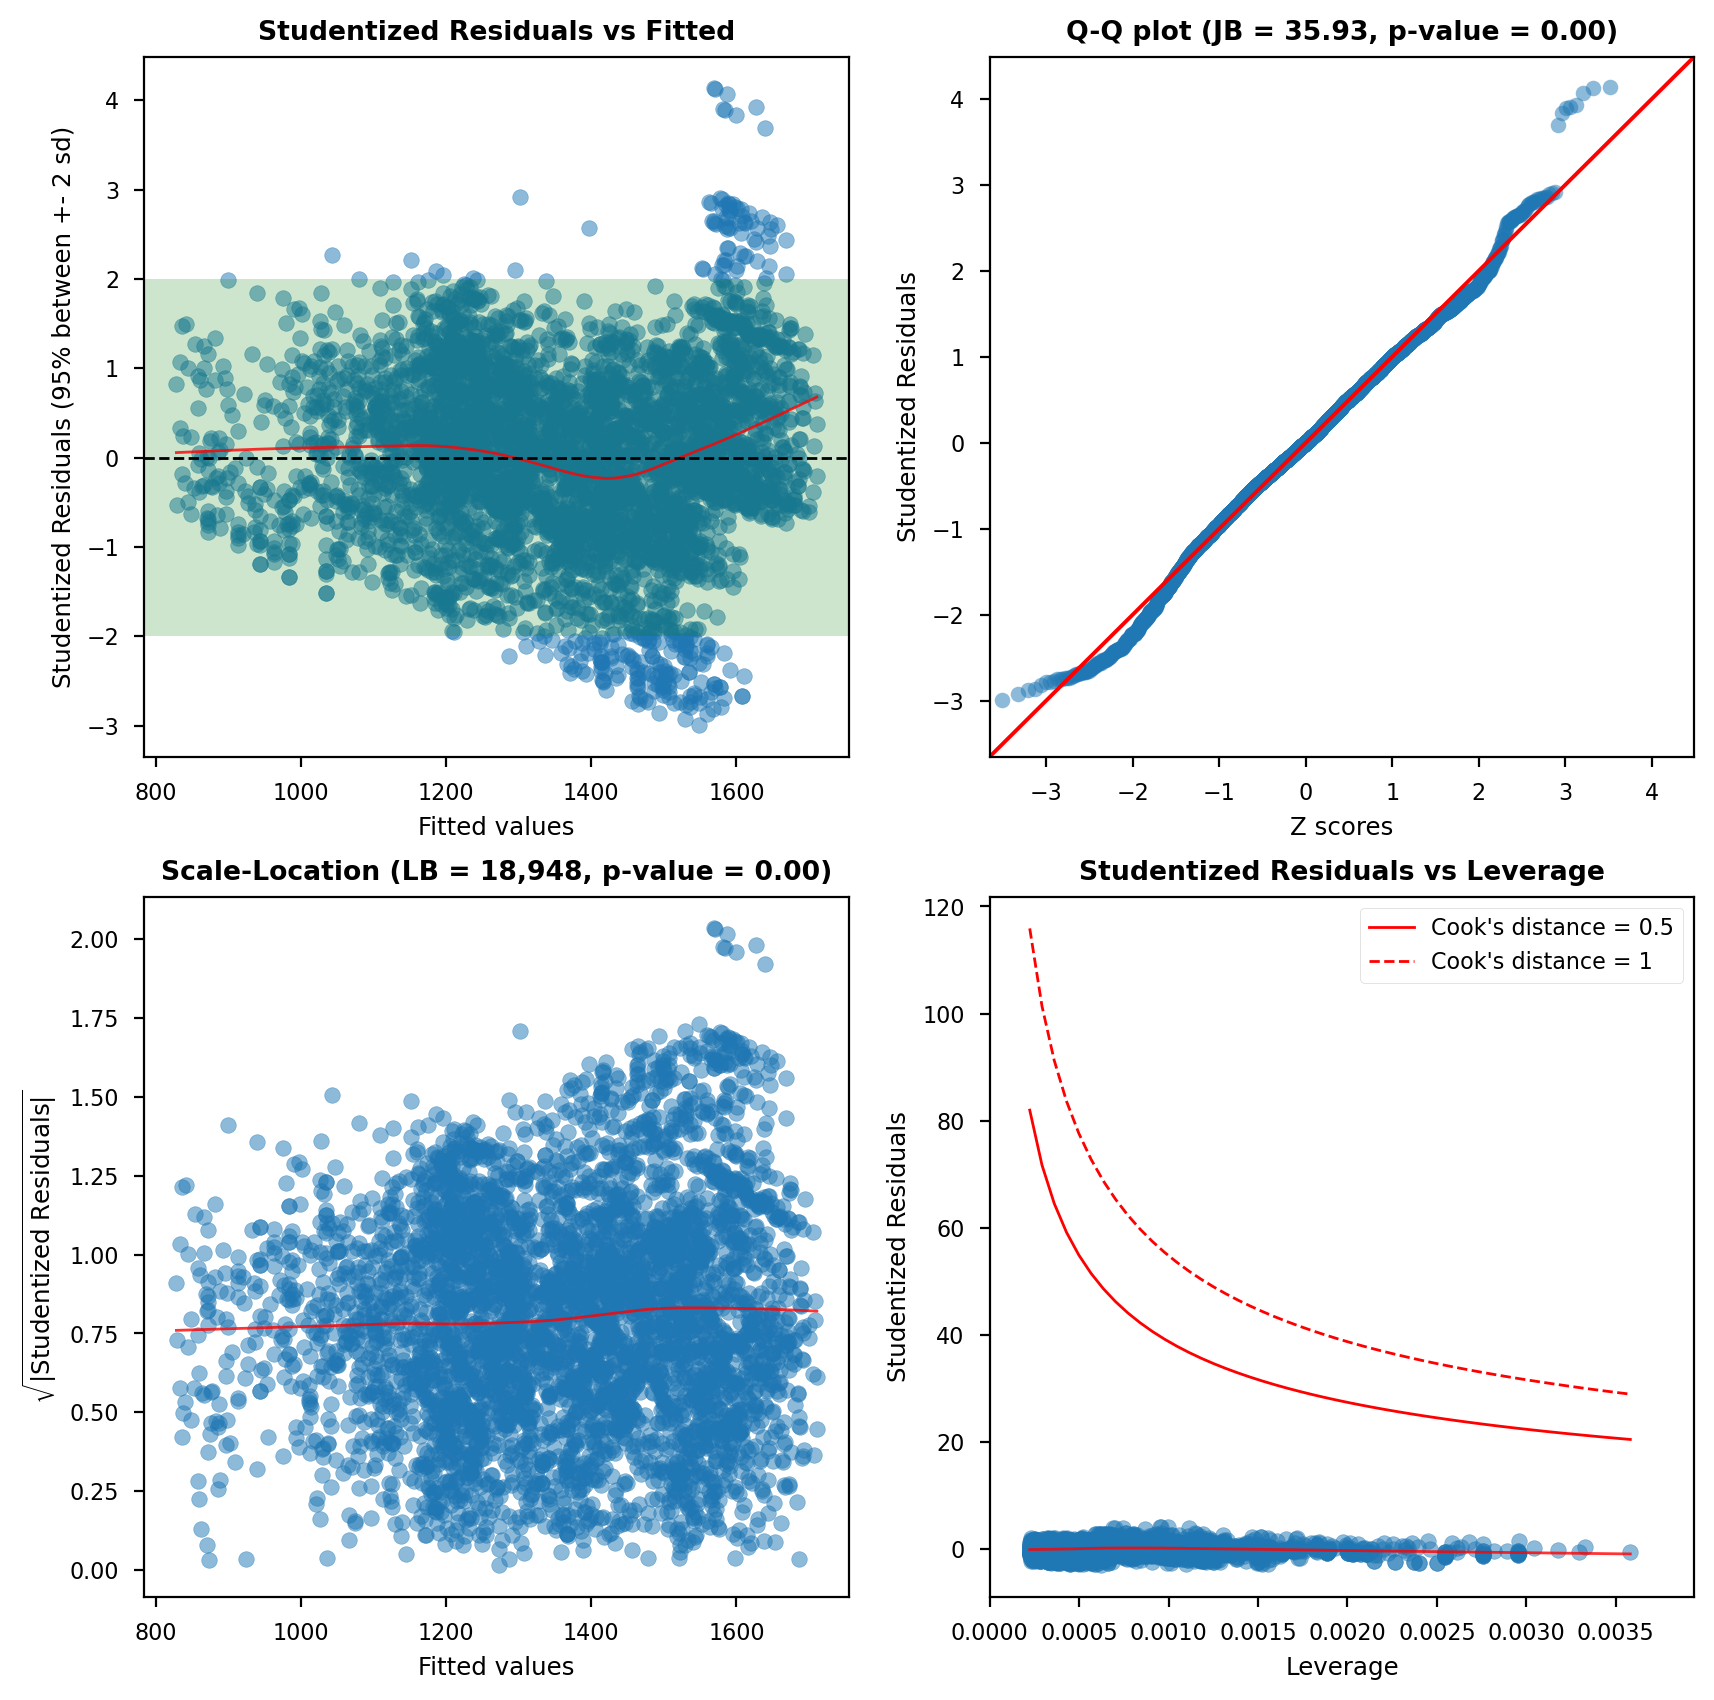

       Features  VIF Factor
0  Lease_Demand        1.04
1      Distance        1.04


In [159]:
cls = Linear_Reg_Diagnostics(best_subset)
fig, ax = cls()

## Difference among neighbourhoods?
- if there is no difference, we can model the average lease rate as a single time series
- otherwise we need to model each neighbourhood separately

In [ ]:
# Instead of performing an ANOVA to see if we can assume all neighbourhoods share the same average lease rate,
# We can perform an F test for the regression of Rent against dummy variables representing each neighborhoods
# if at least one of the params is different from 0, we can reject the null hypothesis that all neighbourhoods share the same average rent
# the F statistic here is large enough for us to reject the null
sm.OLS(regression_df[Y], sm.add_constant(pd.get_dummies(regression_table['Hood_ID']))).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rent   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     66.27
Date:                Sat, 07 May 2022   Prob (F-statistic):               0.00
Time:                        17:53:35   Log-Likelihood:                -29814.
No. Observations:                4480   AIC:                         5.991e+04
Df Residuals:                    4340   BIC:                         6.081e+04
Df Model:                         139                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1353.3555      2.832    477.828      0.000    1347.803    1358.908
1           -225.9532     33.631     -6.719      0.000    -291.887    -160.019
10            12.0098     33.631      0.357      0.721     -53.924      77.944
100          196.3178     33.631      5.837      0.000     130.384     262.252
101          196.3178     33.631      5.837      0.000     130.384     262.252
102          118.4788     33.631      3.523      0.000      52.545     184.413
103          118.4788     33.631      3.523      0.000      52.545     184.413
104          292.2128     33.631      8.689      0.000     226.279     358.147
105          118.4788     33.631      3.523      0.000      52.545     184.413
106          196.3178     33.631      5.837      0.000     130.384     262.252
107          196.3178     33.631      5.837      0.000     130.384     262.252
108         -127.6513     33.631     -3.796      0.000    -193.585     -61.718
109         -267.0796     33.631     -7.941      0.000    -333.013    -201.146
11            12.0098     33.631      0.357      0.721     -53.924      77.944
110         -267.0796     33.631     -7.941      0.000    -333.013    -201.146
111         -267.0796     33.631     -7.941      0.000    -333.013    -201.146
112         -127.6513     33.631     -3.796      0.000    -193.585     -61.718
113         -127.6513     33.631     -3.796      0.000    -193.585     -61.718
114          196.4096     33.631      5.840      0.000     130.476     262.343
115         -127.6513     33.631     -3.796      0.000    -193.585     -61.718
116         -276.8182     33.631     -8.231      0.000    -342.752    -210.884
117         -276.8182     33.631     -8.231      0.000    -342.752    -210.884
118         -276.8182     33.631     -8.231      0.000    -342.752    -210.884
119         -281.3806     33.631     -8.367      0.000    -347.314    -215.447
12            12.0098     33.631      0.357      0.721     -53.924      77.944
120         -281.3806     33.631     -8.367      0.000    -347.314    -215.447
121          -78.1144     33.631     -2.323      0.020    -144.048     -12.181
122          -78.1144     33.631     -2.323      0.020    -144.048     -12.181
123         -378.3139     33.631    -11.249      0.000    -444.248    -312.380
124         -281.3806     33.631     -8.367      0.000    -347.314    -215.447
125         -281.3806     33.631     -8.367      0.000    -347.314    -215.447
126         -281.3806     33.631     -8.367      0.000    -347.314    -215.447
127          -91.3663     33.631     -2.717      0.007    -157.300     -25.432
128         -239.3390     33.631     -7.117      0.000    -305.273    -173.405
129         -239.3390     33.631     -7.117      0.000    -305.273    -173.405
13            12.0098     33.631      0.357      0.721     -53.924      77.944
13